# Imports

In [58]:
import numpy as np
import matplotlib.pyplot as plt

from py_wake.site._site import UniformSite
from py_wake.site.shear import PowerShear
from py_wake.flow_map import Points

from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models import BastankhahGaussianDeficit
from py_wake.superposition_models import LinearSum

# Site and turbines

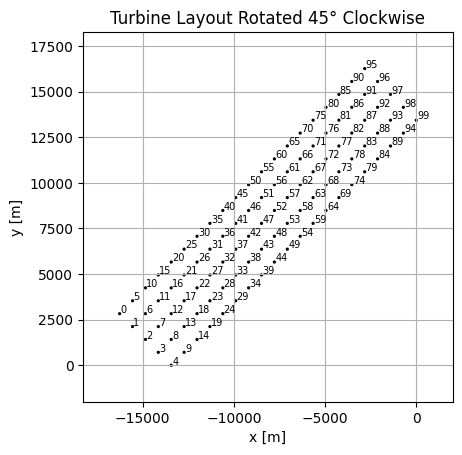

In [59]:
po = [0, 0, 0, 0, 0, 0, 0, 49, 97, 183, 268, 369, 470, 580, 722, 900, 1103, 1315, 1526, 1705, 1883, 1940, 1980, 1995, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000] # https://www.thewindpower.net/turbine_en_779_vestas_v100-2000.php
ct = 0.8 * np.ones_like(po)
u = np.linspace(0, len(po), len(po))

turbine = WindTurbine(name = 'V100',
                      diameter = 100,
                      hub_height = 100,
                      powerCtFunction = PowerCtTabular(u, po, 'kW', ct))
s = 10 * turbine.diameter()

site = UniformSite(shear=PowerShear(h_ref=turbine.hub_height(), alpha=.1))

n_rows = 20
n_cols = 5

x_grid, y_grid = np.meshgrid(np.arange(n_cols) * s,
                             np.arange(n_rows) * s)

x = x_grid.ravel()
y = y_grid.ravel()

theta_deg = 45
theta_rad = -np.radians(theta_deg)

rotation_matrix = np.array([
    [np.cos(theta_rad), -np.sin(theta_rad)],
    [np.sin(theta_rad),  np.cos(theta_rad)]
])

xy_rotated = rotation_matrix @ np.vstack([x, y])
x, y = xy_rotated[0], xy_rotated[1]

x = x - np.max(x) # Set x=0 at downstream edge
y = y - np.min(y) # Set y=0 at bottommost turbine

padding = 2000 # Padding for display

fig, ax = plt.subplots()
turbine.plot(x, y, ax=ax)
ax.set_xlim(min(x) - padding, max(x) + padding)
ax.set_ylim(min(y) - padding, max(y) + padding)
ax.set_title(f"Turbine Layout Rotated {theta_deg}° Clockwise")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_aspect('equal')
ax.grid(True)
plt.show()

# Flow map

Text(0.5, 1.0, 'Wake map for 270 deg and 10 m/s')

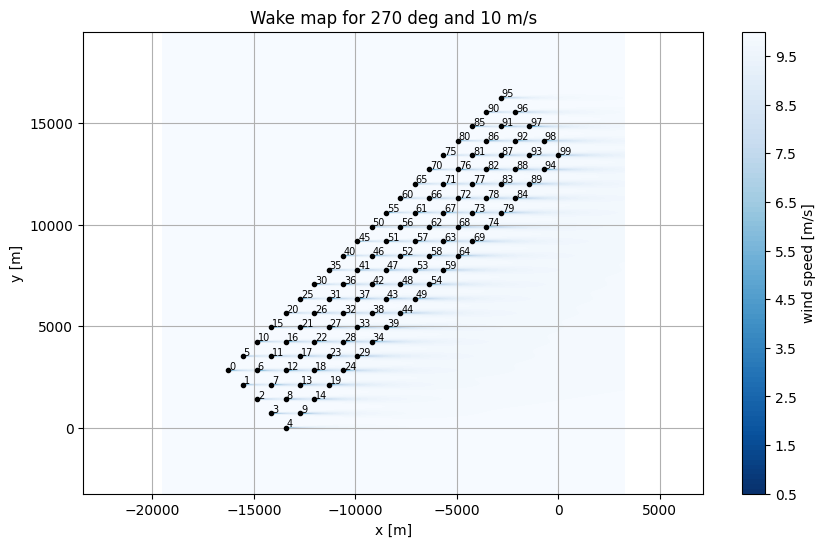

In [60]:
wdir = 270 # [deg]
wsp = 10 # [m/s]
ti = .1

wfm = PropagateDownwind(site, turbine, wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True), superpositionModel=LinearSum())
sim = wfm(x, y, ws=wsp, wd=wdir, TI=ti)

fig, ax = plt.subplots(figsize=(10, 6))
sim.flow_map().plot_wake_map()
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_aspect('equal')
ax.grid(True)
ax.set_title('Wake map for'+ f' {wdir} deg and {wsp} m/s')

# Wind speed profiles

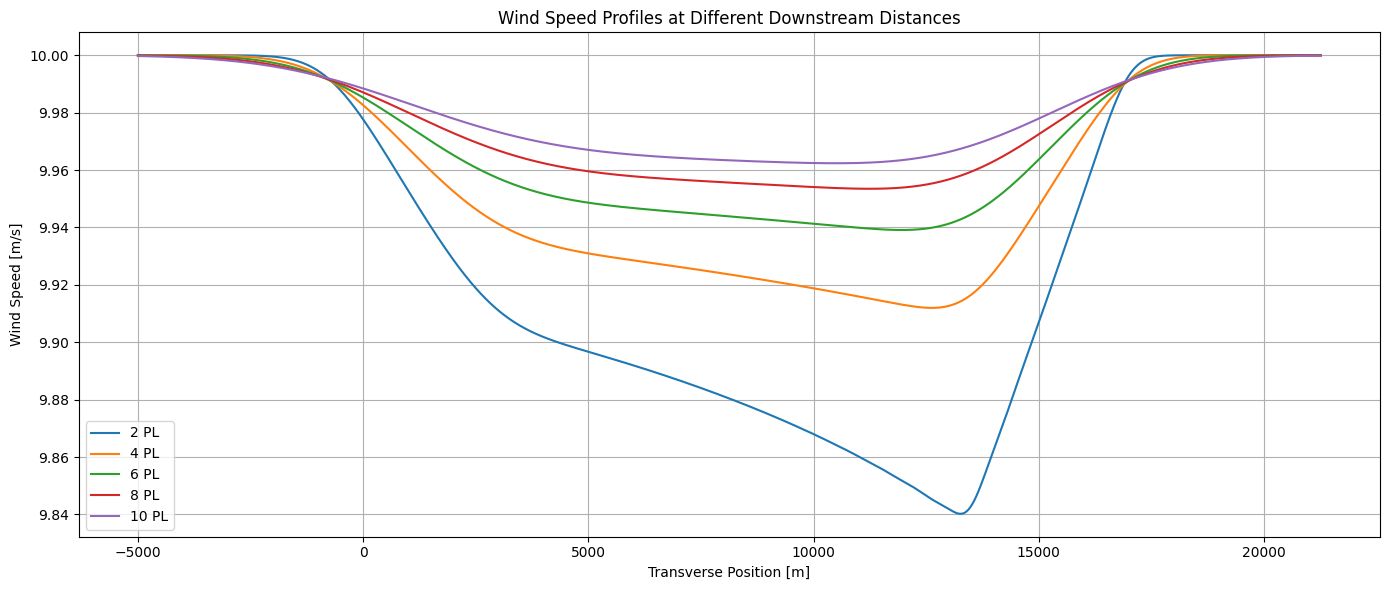

In [61]:
pl_downstream = [2, 4, 6, 8, 10]  # Downstream distances [Park lengths]
m_downstream = [pl * 5660 for pl in pl_downstream] # * (max(x) - min(x)) for pl in pl_downstream]  # [m]

w_meas = 5000  # Half-width of measurement area [m]

y_range = np.linspace(min(y) - w_meas, max(y) + w_meas, w_meas)
y_meas = np.tile(y_range[:, np.newaxis], (1, len(m_downstream)))  # Shape: (w_meas, len(m_downstream))

ws_meas = np.zeros_like(y_meas)

# Create a single plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_xlabel('Transverse Position [m]')
ax.set_ylabel('Wind Speed [m/s]')
ax.set_title('Wind Speed Profiles at Different Downstream Distances')
ax.grid(True)

for i, m in enumerate(m_downstream):
    x_meas = np.full(y_meas.shape[0], max(x) + m)

    ws_meas[:, i] = np.squeeze(
        sim.flow_map(Points(
            x=x_meas,
            y=y_meas[:, i],
            h=turbine.hub_height() * np.ones_like(y_meas[:, i])
        )).WS_eff.values
    )
    
    ax.plot(y_meas[:, i], ws_meas[:, i], label=f'{pl_downstream[i]} PL')

ax.legend()
plt.tight_layout()
plt.show()

# Measurement lines

C:\Users\Marcin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


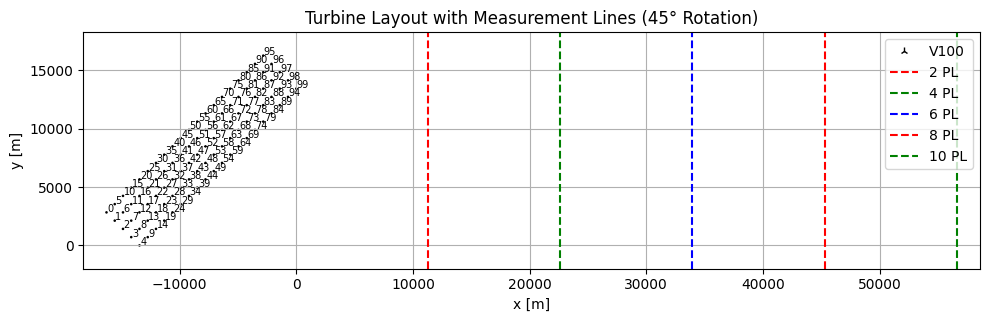

In [62]:
padding = 2000  # Padding for display

fig, ax = plt.subplots(figsize=(10, 6))
turbine.plot(x, y, ax=ax)

# Set plot limits with padding
ax.set_xlim(min(x) - padding, max(x) + max(m_downstream) + padding)
ax.set_ylim(min(y) - padding, max(y) + padding)

# Draw vertical lines at each x_meas (same for all points in a column)
colors = ['r', 'g', 'b']  # Define a list of colors for the lines
for i, m in enumerate(m_downstream):
    x_line = max(x) + m
    ax.axvline(x=x_line, linestyle='--', color=colors[i % len(colors)], label=f'{pl_downstream[i]} PL')  # Add label for legend

# Beautify
ax.set_title(f"Turbine Layout with Measurement Lines ({theta_deg}° Rotation)")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_aspect('equal')
ax.grid(True)

# Only show one legend entry per PL
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))  # Remove duplicate labels
ax.legend(unique.values(), unique.keys())

plt.tight_layout()
plt.show()

# Load validation data from TDM

In [63]:
import os
import pandas as pd

# Path to the ValidationData folder
validation_data_path = "ValidationData"

# List all files in the folder
validation_files = [f for f in os.listdir(validation_data_path) if os.path.isfile(os.path.join(validation_data_path, f))]

# Load datasets into a dictionary of DataFrames
validation_datasets = {}
for file in validation_files:
    file_path = os.path.join(validation_data_path, file)
    if file.endswith('.csv'):
        validation_datasets[file] = pd.read_csv(file_path)
    elif file.endswith('.xlsx'):
        validation_datasets[file] = pd.read_excel(file_path)

# Print the names of the loaded datasets
print("Loaded datasets:", list(validation_datasets.keys()))

Loaded datasets: ['RectangleRotated10PL.csv', 'RectangleRotated2PL.csv', 'RectangleRotated4PL.csv', 'RectangleRotated6PL.csv', 'RectangleRotated8PL.csv']


# Repeat velocity profile plot with TDM comparison

11868.0
y_meas_max:  28131.455967290593


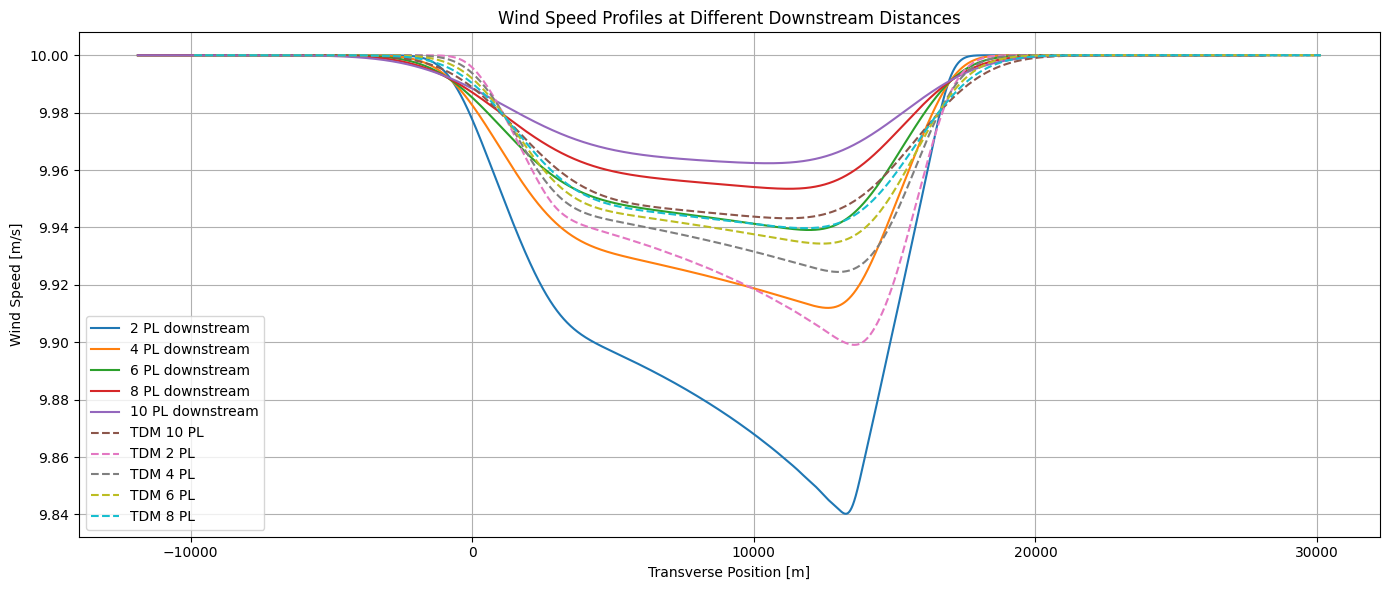

In [ ]:
pl_downstream = [2, 4, 6, 8, 10]  # Downstream distances [Park lengths]
m_downstream = [pl * 5660 for pl in pl_downstream] # * (max(x) - min(x)) for pl in pl_downstream]  # [m]

w_meas = (40000 - int(np.ceil(max(y)))) / 2  # Extra measurement width on each side [m]

y_range = np.linspace(min(y) - w_meas, max(y) + w_meas, int(np.ceil(max(y))) + (40000 - int(np.ceil(max(y)))))
y_meas = np.tile(y_range[:, np.newaxis], (1, len(m_downstream)))  # Shape: (w_meas, len(m_downstream))

ws_meas = np.zeros_like(y_meas)

# Create a single plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_xlabel('Transverse Position [m]')
ax.set_ylabel('Wind Speed [m/s]')
ax.set_title('Wind Speed Profiles at Different Downstream Distances')
ax.grid(True)

# Draw PyWake graphs
for i, m in enumerate(m_downstream):
    x_meas = np.full(y_meas.shape[0], max(x) + m)

    ws_meas[:, i] = np.squeeze(
        sim.flow_map(Points(
            x=x_meas,
            y=y_meas[:, i],
            h=turbine.hub_height() * np.ones_like(y_meas[:, i])
        )).WS_eff.values
    )
    
    ax.plot(y_meas[:, i], ws_meas[:, i], label=f'{pl_downstream[i]} PL downstream')

# Draw TDM graphs
for file in validation_files:
    # Extract downstream distance from the file name
    downstream_distance = int(file.split('PL')[0].split('RectangleRotated')[-1])
    
    # Get the corresponding dataset
    tdm_data = validation_datasets[file]
    
    # Plot the TDM data as dashed lines
    ax.plot(
        y_range, 
        tdm_data.values.flatten(), 
        linestyle='--', 
        label=f'TDM {downstream_distance} PL'
    )


ax.legend()
plt.tight_layout()
plt.show()